In [1]:
# !pip install transformers accelerate datasets diffusers Pillow==9.4.0

For Imagenet processing we have to do things a bit different:
* Load recaptioned dataset
* Resize using HF's built-in multiprocessing
* Generate latents in batches
* Reupload to HF

In [2]:
import torchvision.transforms as T
import torch
import random
from datasets import load_dataset, Dataset, DatasetDict
from diffusers import AutoencoderDC
from torch.utils.data import DataLoader
from utils import make_grid, PIL_to_latent, latent_to_PIL, dcae_scalingf
from tqdm import tqdm

from PIL import PngImagePlugin
# otherwise might lead to Decompressed Data Too Large for some images
LARGE_ENOUGH_NUMBER = 10
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load IN1k recaptions dataset

In [3]:
ds = load_dataset("visual-layer/imagenet-1k-vl-enriched", cache_dir="~/ssd-2TB/hf_cache")

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/205 [00:00<?, ?it/s]

In [4]:
print("splits", ds.keys())
print("features", ds["train"].features.keys())

splits dict_keys(['train', 'validation'])
features dict_keys(['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'])


In [5]:
# # find the one weird image
# image=None

# resizeTo = 96

# def augment(img, do_flip=False, do_contrast=False):
#     def noop(x): return x
#     transform = T.Compose([
#         lambda x: x.convert('RGB') if x.mode!="RGB" else x,
#         T.Resize(resizeTo, antialias=True) if resizeTo is not None else skipT,
#         T.CenterCrop(resizeTo),
#         T.RandomHorizontalFlip(p=1 if do_flip else 0),
#         T.RandomAutocontrast(p=1 if do_contrast else 0),
#     ])
#     return transform(img)

# ds_shuffled = ds["train"].shuffle()

# for row in tqdm(ds_shuffled):
#     image=row["image"]
#     image_aug = augment(image)
    

## Inspect augmentation before actually processing

a person ironing a shirt



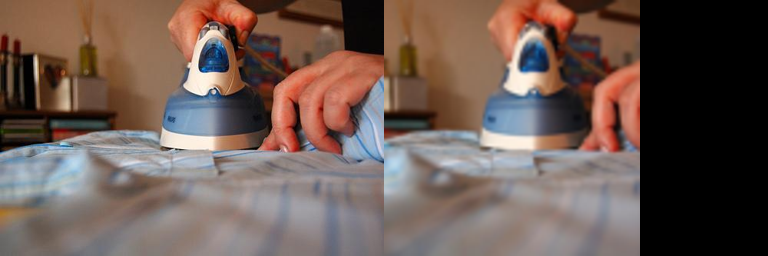

a group of kids playing musical instruments



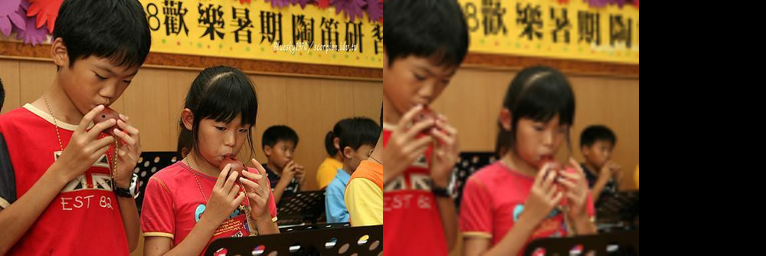

band aid shes5, white, 100/box



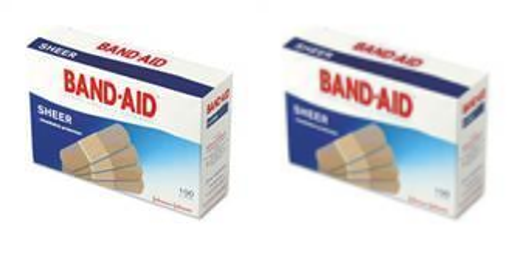

a basset dog wearing a yellow baseball cap



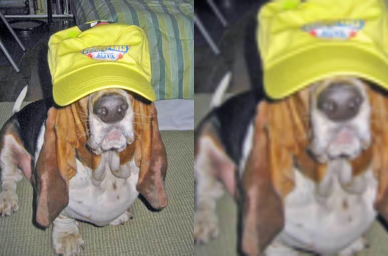

a white pomeranian dog sitting on a red blanket



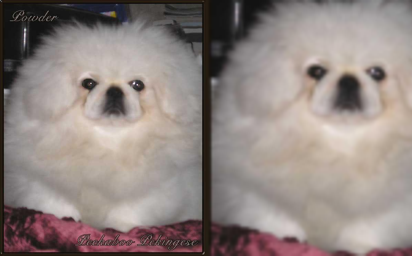

a plate of pasta



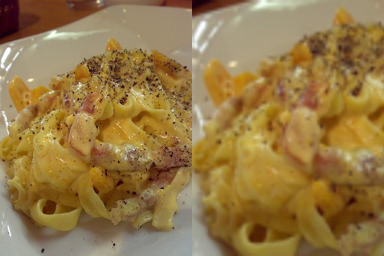

a woman in a red swim suit



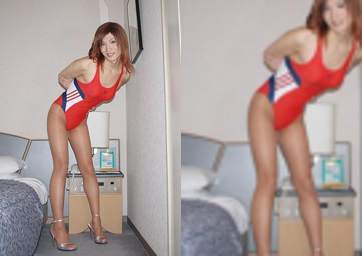

a lizard with a long tongue



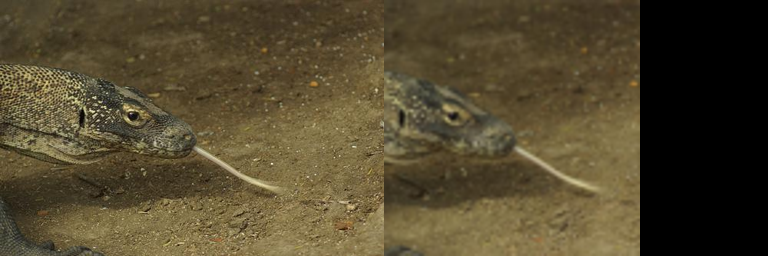

a woman standing next to a dog in an arena



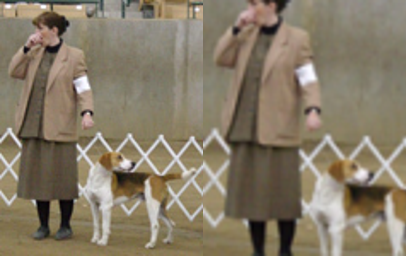

a small dog sitting in front of an orange wall



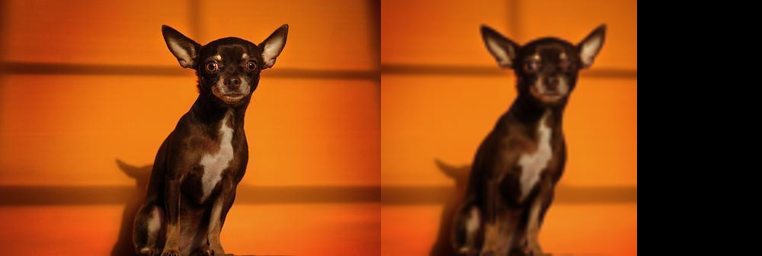

In [6]:
resizeTo = 96
split = "train"

def augment(img, do_flip=False, do_contrast=False):
    def noop(x): return x
    transform = T.Compose([
        lambda x: x.convert('RGB') if x.mode!="RGB" else x,
        T.Resize(resizeTo, antialias=True) if resizeTo is not None else skipT,
        T.CenterCrop(resizeTo),
        T.RandomHorizontalFlip(p=1 if do_flip else 0),
        T.RandomAutocontrast(p=1 if do_contrast else 0),
    ])
    return transform(img)

for i in [random.randint(0, len(ds[split])) for _ in range(10)]:
    img=ds[split][i]["image"]
    label=ds[split][i]["caption_enriched"]
    images = []
    
    images.append( img.resize((round(img.width/img.height*256),256)) )
    images.append( augment(img).resize((256,256)) )
    # images.append( augment(img, do_flip=True).resize((256,256)) )
    # images.append( augment(img, do_contrast=True).resize((256,256)) )
    # images.append( augment(img, do_flip=True, do_contrast=True).resize((256,256)) )

    print(label)
    display(make_grid(images))

# Load DCAE

In [7]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# Batch augment and create dataset

In [8]:
def collate(items):
    labels = [item["caption_enriched"] for item in items]
    images = [augment(item["image"]) for item in items]
    return labels, images

In [11]:
test_run = False
batch_size = 128
resizeTo = 96
dataset_latents = {}
splits=["train", "validation"]

for split in splits:
    # Change the dataset !
    dataloader = DataLoader(
        ds[split], 
        batch_size = batch_size, 
        shuffle=False, 
        collate_fn=collate,
        num_workers=10,
        prefetch_factor=2,
    )
    dataset_latents[split]=[]
    
    for labels, images in tqdm(dataloader, f"split {split}"):
        latents = PIL_to_latent(images, dcae).float().cpu()   # shape [B * latents_per_img, ..., C, W, H]
    
        for i, label in enumerate(labels):
            latent = latents[None, i]
            if test_run: print(latent.shape)
            dataset_latents[split].append({
                "label": label,
                "num_latents": 1,
                "latent": latent 
            })
        if test_run: break

split train:  63%|███████████████▊         | 6338/10010 [22:30<13:21,  4.58it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

split validation: 100%|███████████████████████| 391/391 [01:24<00:00,  4.61it/s]


split train
two eggs are cooking in a frying pan
 torch.Size([1, 32, 3, 3])


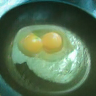

a fighter jet flying in the sky
 torch.Size([1, 32, 3, 3])


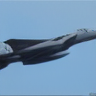

a building with a sign that says family leisure
 torch.Size([1, 32, 3, 3])


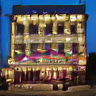

a close up of a sewing machine
 torch.Size([1, 32, 3, 3])


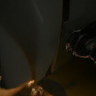

a large boat with sails
 torch.Size([1, 32, 3, 3])


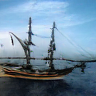

a green bird sitting on a branch in the forest
 torch.Size([1, 32, 3, 3])


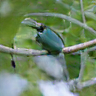

a group of people on a boat with a whale
 torch.Size([1, 32, 3, 3])


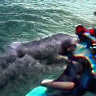

a table with crab legs and rice
 torch.Size([1, 32, 3, 3])


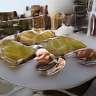

a duck is swimming in the water
 torch.Size([1, 32, 3, 3])


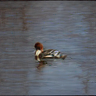

a white bowl and a wooden table
 torch.Size([1, 32, 3, 3])


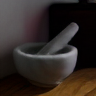

a small black and brown puppy standing on a tile floor
 torch.Size([1, 32, 3, 3])


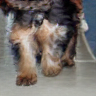

three bottles of baleilur extract
 torch.Size([1, 32, 3, 3])


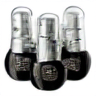

split validation
a dog is sitting in the grass with its mouth open
 torch.Size([1, 32, 3, 3])


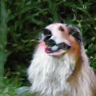

a monkey with a long nose
 torch.Size([1, 32, 3, 3])


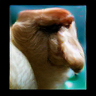

a black necklace with black flowers on it
 torch.Size([1, 32, 3, 3])


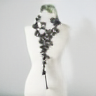

a white mushroom with a large white cap on the ground
 torch.Size([1, 32, 3, 3])


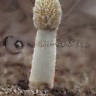

a black and tan dog standing on a sidewalk
 torch.Size([1, 32, 3, 3])


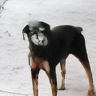

a table with bowls of chips and salsa
 torch.Size([1, 32, 3, 3])


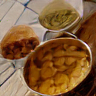

a bird nest
 torch.Size([1, 32, 3, 3])


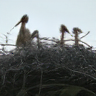

orange slices on a plate
 torch.Size([1, 32, 3, 3])


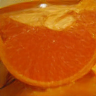

a large ornate wooden pulpit
 torch.Size([1, 32, 3, 3])


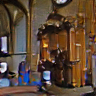

two men in red uniforms riding horses
 torch.Size([1, 32, 3, 3])


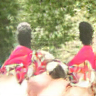

a building with a clock tower and lights
 torch.Size([1, 32, 3, 3])


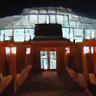

a television on a shelf
 torch.Size([1, 32, 3, 3])


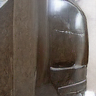

In [12]:
# check a few samples
num_samples = 12
dataset = dataset_latents
for split in dataset_latents:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(num_samples)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label, latent.shape)
        display(
            # make_grid(
                latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
            # )
        )

# Upload

In [13]:
dataset = DatasetDict({
    split: Dataset.from_list(dataset_latents[split]) 
    for split in dataset_latents
})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['label', 'num_latents', 'latent'],
        num_rows: 50000
    })
})

split train
a sewing machine on a table



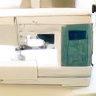

a stack of burritos



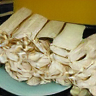

a knife on a wall



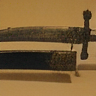

a gray fox is sitting on a branch



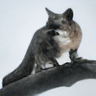

three different colored plastic plates with a plastic cover



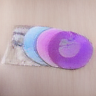

split validation
a white and green rv parked in a garage



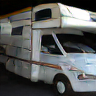

a beetle with horns



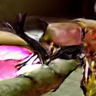

a dog sitting on a bench



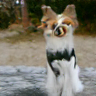

a car on a flatbed truck



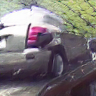

a small dog running on a cobblestone street



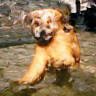

In [14]:
# check a few samples
for split in splits:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(5)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label)
        display(
            # make_grid(
                latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
            # )
        )

In [16]:
from local_secrets import hf_token
from huggingface_hub import login
login(token=hf_token)

In [20]:
dataset.push_to_hub(
    "g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0", 
    private=True, 
    commit_message=model,
    num_shards={'train': 20, 'test': 4}
)

Uploading the dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/65 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/50 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0/commit/2973260b1b2e315792cca5429ec98c4ec1ad63c1', commit_message='Efficient-Large-Model/Sana_600M_1024px_diffusers', commit_description='', oid='2973260b1b2e315792cca5429ec98c4ec1ad63c1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0', endpoint='https://huggingface.co', repo_type='dataset', repo_id='g-ronimo/IN1k-96-latents_dc-ae-f32c32-sana-1.0'), pr_revision=None, pr_num=None)